# Compare performance across concentration and representation

Compare classifier metrics across different consensus profile strategies, stratefied by representations types. 

In [1]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings

## Input annotations

In [2]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_df = pred_df.filter(pl.col("Model_type") == "Actual")

### Compare concentrations and representations

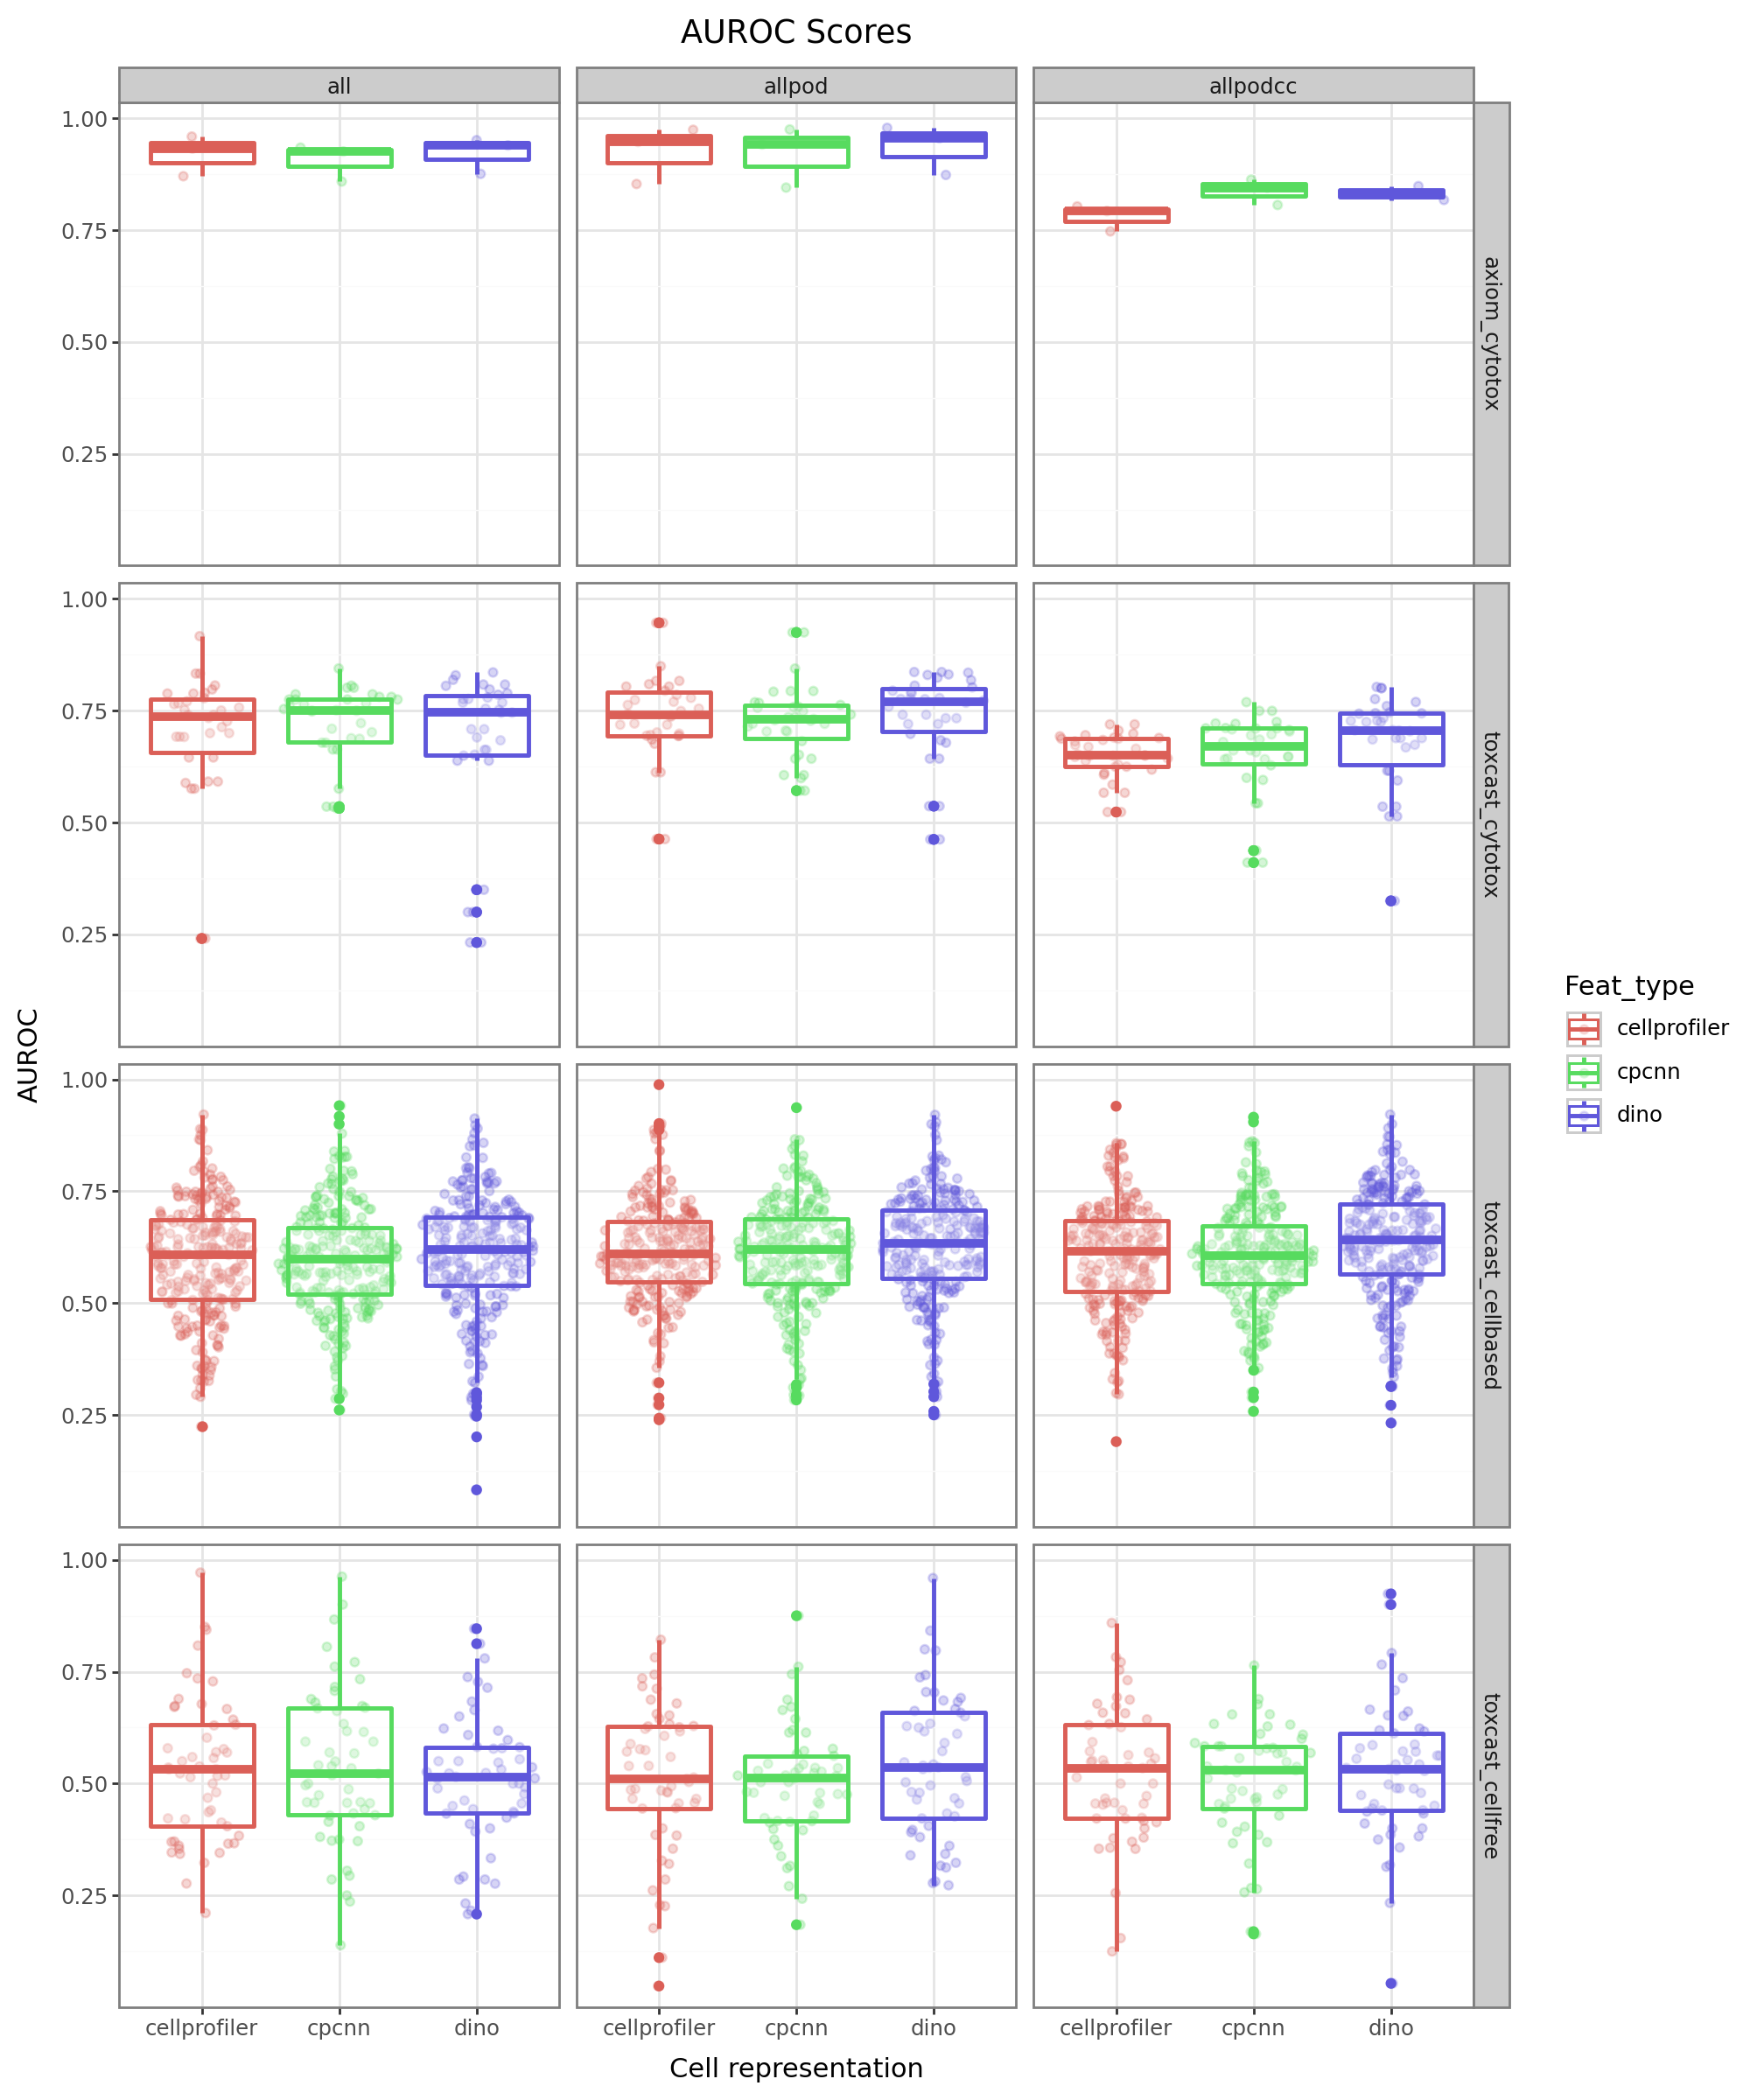

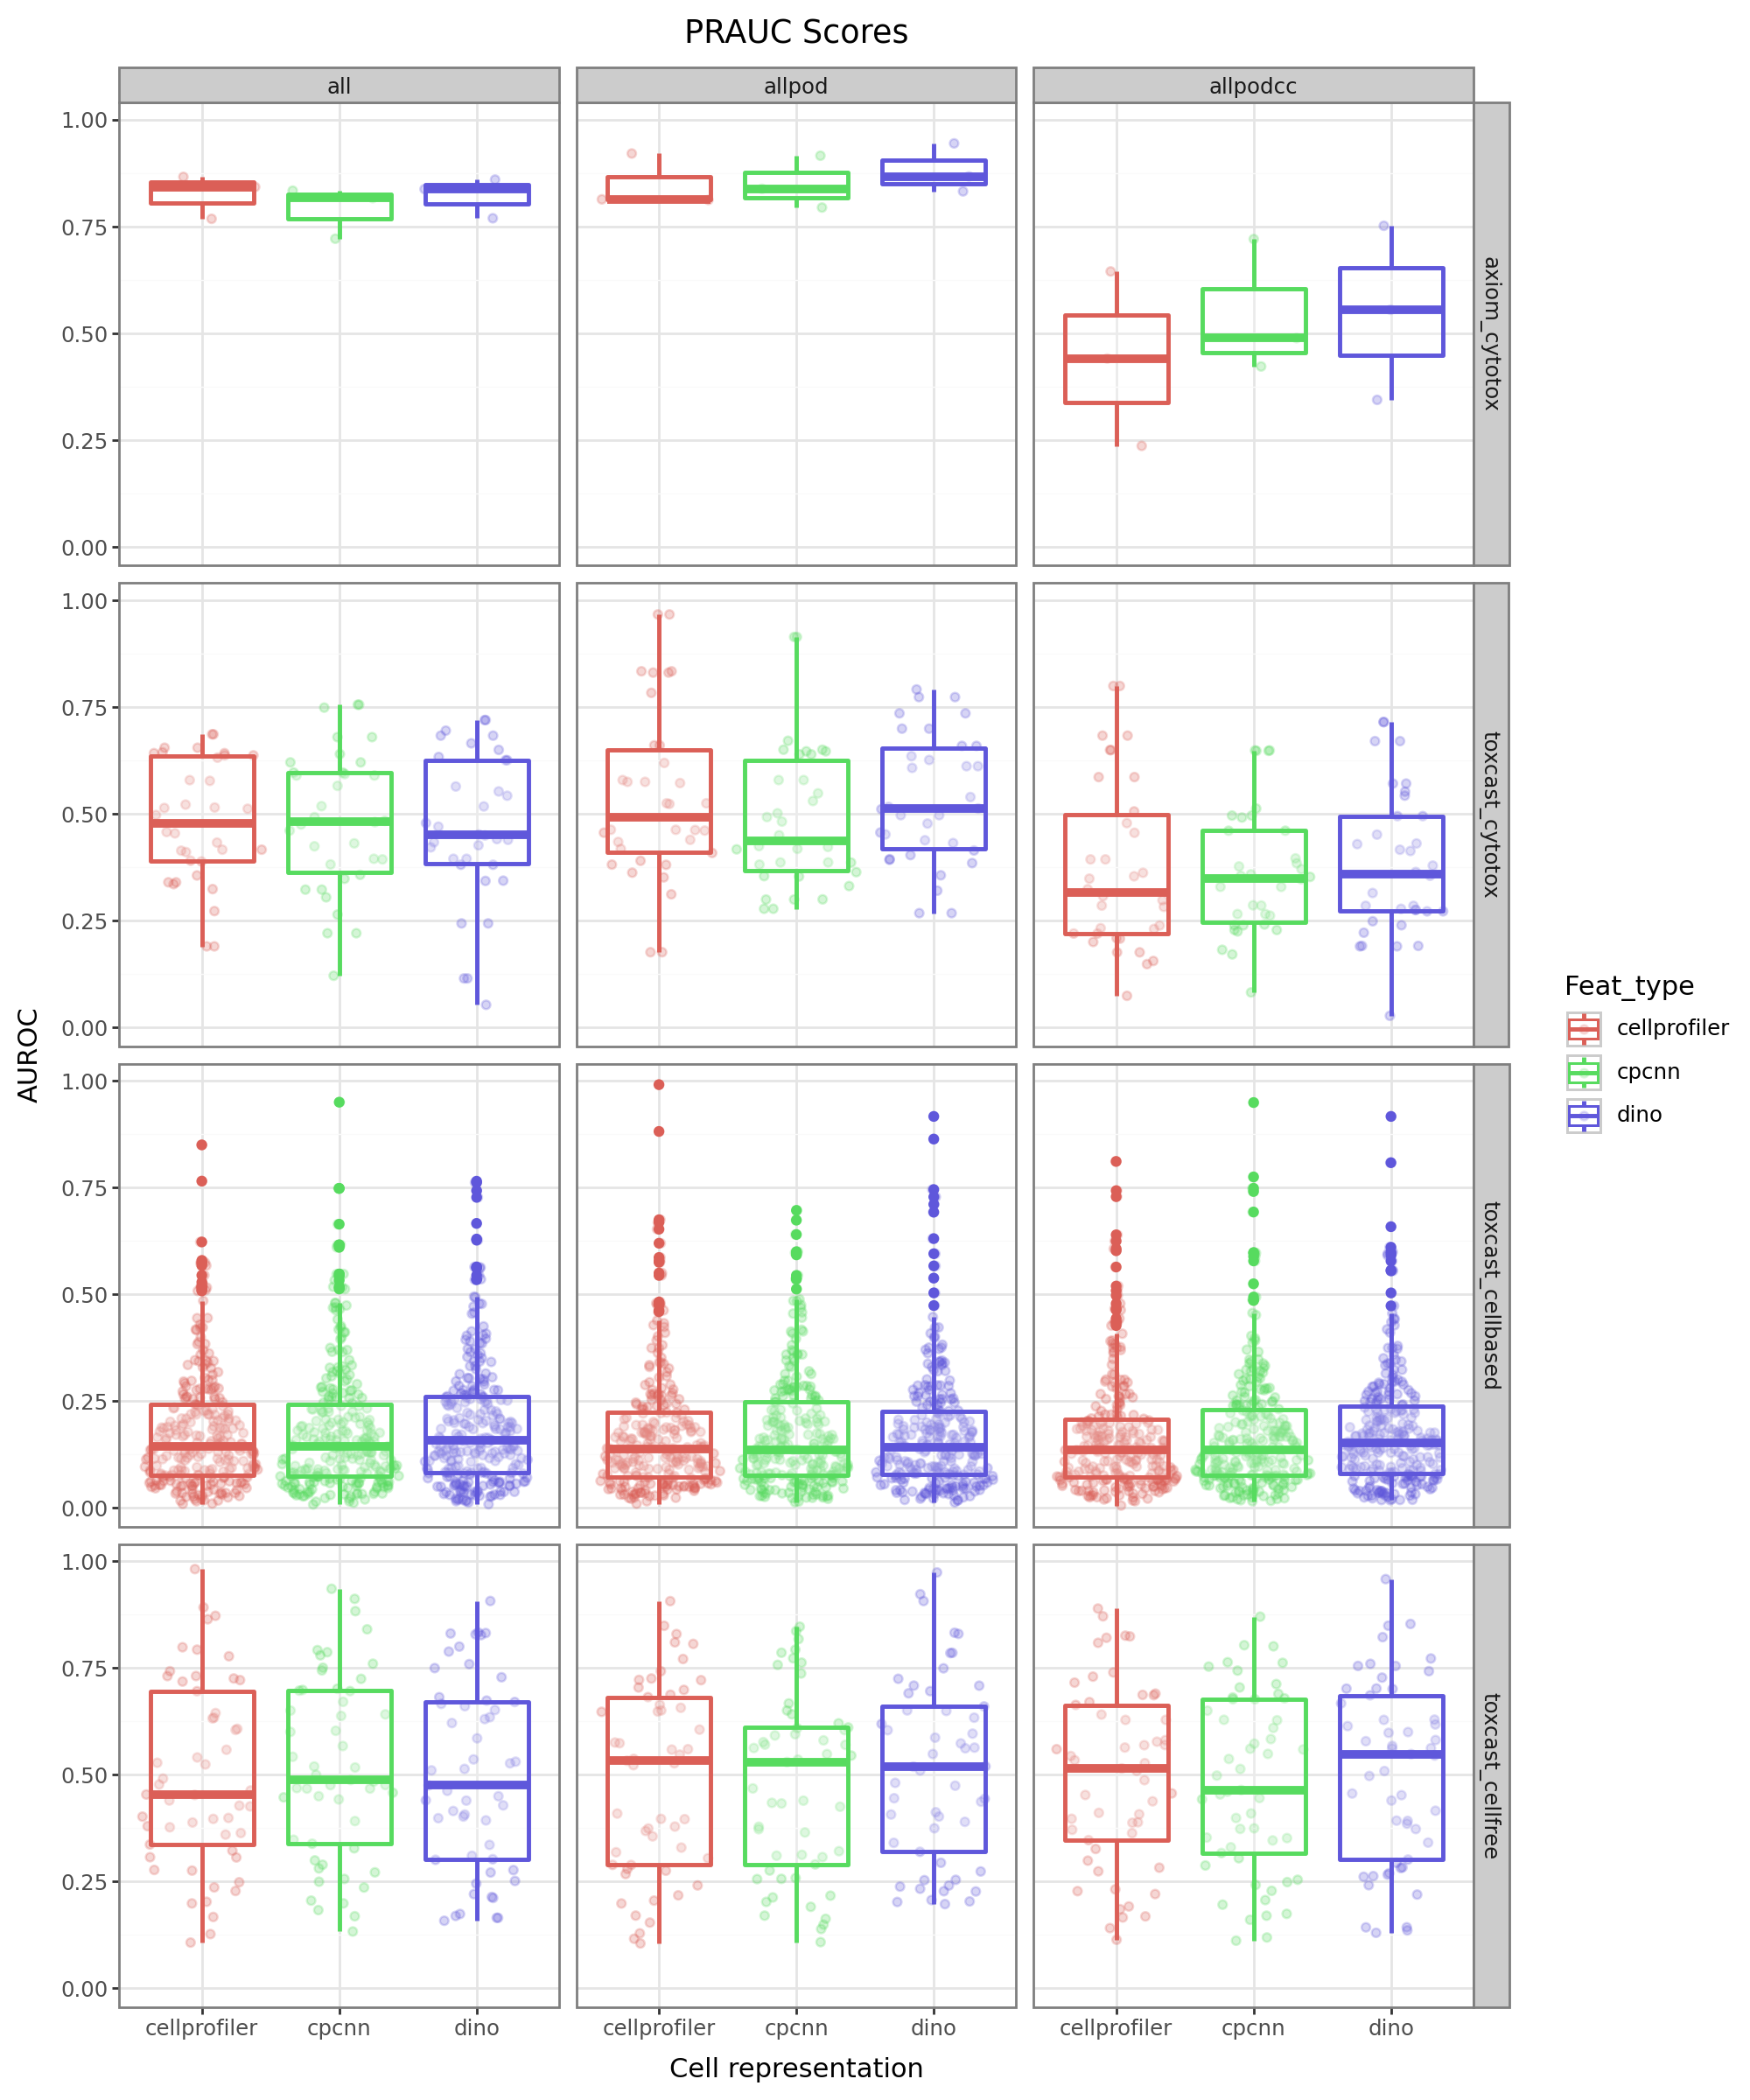

In [4]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_grid
import plotnine as pn

pn.options.figure_size = (10, 12)

pred_pandas = pred_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)

plot = (
    ggplot(pred_pandas, aes(x='Feat_type', y='AUROC', color="Feat_type")) 
    + geom_sina(alpha=0.25) 
    + geom_boxplot(alpha=0.25, size=1)
    + facet_grid("Endpoint_type ~ Metadata_AggType")
    + labs(title='AUROC Scores', x='Cell representation', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Feat_type', y='PRAUC', color="Feat_type")) 
    + geom_sina(alpha=0.25) 
    + geom_boxplot(alpha=0.25, size=1)
    + facet_grid("Endpoint_type ~ Metadata_AggType")
    + labs(title='PRAUC Scores', x='Cell representation', y='AUROC') 
    + theme_bw()
)
plot.show()

## Compute statistics

### Across consensus strategies

In [7]:
warnings.filterwarnings("ignore")

auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "AUROC ~ Metadata_AggType", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Feat_type"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Metadata_AggType"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0107 0.7456 -0.0257  0.0472  False
   all allpodcc  -0.0992    0.0 -0.1357 -0.0627   True
allpod allpodcc  -0.1099    0.0 -0.1464 -0.0735   True
------------------------------------------------------
P-values: [7.45577030e-01 1.46786169e-06 2.67441219e-07]
Processing Endpoint_type: toxcast_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0377 0.0005  0.0143  0.0611   True
   all allpodcc  -0.0388 0.0003 -0.0622 -0.0154   True
allpod allpodcc  -0.0765    0.0    -0.1 -0.0531   True
------------------------------------------------------
P-values: [5.22783218e-04 3.41129511e-04 5.75317571e-13]
Processing Endpoint_type: toxcast_

In [8]:
prauc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "PRAUC ~ Metadata_AggType", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Feat_type"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Metadata_AggType"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    prauc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0471 0.2734 -0.0274  0.1216  False
   all allpodcc  -0.3012    0.0 -0.3757 -0.2267   True
allpod allpodcc  -0.3484    0.0 -0.4229 -0.2739   True
------------------------------------------------------
P-values: [2.73377913e-01 1.20164267e-09 6.49109655e-11]
Processing Endpoint_type: toxcast_cytotox
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0436 0.0515 -0.0002  0.0875  False
   all allpodcc  -0.1049    0.0 -0.1487  -0.061   True
allpod allpodcc  -0.1485    0.0 -0.1924 -0.1047   True
------------------------------------------------------
P-values: [5.14627285e-02 1.20572007e-07 8.39328607e-14]
Processing Endpoint_type: toxcast_

### Across representations

In [9]:
auroc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "AUROC ~ Feat_type", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Metadata_AggType"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Feat_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    auroc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn   0.0128 0.9052  -0.062 0.0875  False
cellprofiler   dino   0.0213 0.7596 -0.0535 0.0961  False
       cpcnn   dino   0.0085 0.9563 -0.0663 0.0833  False
---------------------------------------------------------
P-values: [0.90524821 0.7595677  0.95634277]
Processing Endpoint_type: toxcast_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn   0.0027 0.9626 -0.0213 0.0266  False
cellprofiler   dino   -0.004 0.9179  -0.028 0.0199  False
       cpcnn   dino  -0.0067 0.7884 -0.0306 0.0173  False
---------------------------------------------------------
P-values: [0.96264054 0.9178909  0.78844527]
Processing Endpo

In [10]:
prauc_results = {}

for endpoint_type, group_data in pred_pandas.groupby("Endpoint_type"):
    print(f"Processing Endpoint_type: {endpoint_type}")
    
    # Fit the mixed-effects model
    model = smf.mixedlm(
        "PRAUC ~ Feat_type", 
        group_data, 
        groups=group_data["Metadata_Label"],
        re_formula="~Metadata_AggType"
    )
    result = model.fit()
    
    # Add fitted values to the subset DataFrame
    group_data["fitted_values"] = result.fittedvalues

    # Perform Tukey's HSD
    mc = MultiComparison(group_data["fitted_values"], group_data["Feat_type"])
    tukey_result = mc.tukeyhsd()
    tukey_pvals = tukey_result.pvalues
    
    # Print results for the current Endpoint_type
    print(tukey_result.summary())
    print("P-values:", tukey_pvals)
    
    # Save results for each Endpoint_type in a dictionary for later reference
    prauc_results[endpoint_type] = {
        "tukey_summary": tukey_result.summary(),
        "tukey_pvalues": tukey_pvals,
        "fitted_model": result
    }

Processing Endpoint_type: axiom_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn   0.0229 0.9649 -0.2018 0.2477  False
cellprofiler   dino   0.0463 0.8651 -0.1784  0.271  False
       cpcnn   dino   0.0233 0.9636 -0.2014 0.2481  False
---------------------------------------------------------
P-values: [0.96485604 0.86510064 0.96363277]
Processing Endpoint_type: toxcast_cytotox
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn  -0.0206 0.5937 -0.0703 0.0291  False
cellprofiler   dino  -0.0042 0.9779 -0.0539 0.0455  False
       cpcnn   dino   0.0163 0.7199 -0.0334  0.066  False
---------------------------------------------------------
P-values: [0.59372434 0.97793831 0.71985   ]
Processing Endpo